# Time Series Analysis using RNN

## Dev's Profile

Nama : Tariq Fitria Aziz <br>
Bergabung: 02 September 2020 <br>
Asal: Kabupaten Wonogiri, Jawa Tengah

## Problem Desc

Di sini, akan dibuat sebuah model Deep Learning yang dapat digunakan untuk melakukan forecast pada sebuah time series, yaitu data stock exchange.

Dataset yang digunakan dapat dilihat di sumber berikut: https://www.kaggle.com/mattiuzc/stock-exchange-data?select=indexProcessed.csv 

## Part I: Preparation

### Import Library

In [24]:
from google.colab import drive

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Set Drive Folder

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## Part II: Data Preparation

### Data Loading

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/indexProcessed.csv')
data.head(5)

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


### Data Information

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104224 entries, 0 to 104223
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      104224 non-null  object 
 1   Date       104224 non-null  object 
 2   Open       104224 non-null  float64
 3   High       104224 non-null  float64
 4   Low        104224 non-null  float64
 5   Close      104224 non-null  float64
 6   Adj Close  104224 non-null  float64
 7   Volume     104224 non-null  float64
 8   CloseUSD   104224 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.2+ MB


KETERANGAN <br>

Index: Ticker symbol for indexes <br>
Date: Date of observation <br>
Open: Opening Price <br>
High: Highest price during trading day <br>
Low: Lowest price during trading day <br>
Close: Closing price <br>
Adj Close: Closing price adjusted for dividends and stock splits <br>
Volume: Number of shares traded during trading day <br>
CloseUSD: Close price in terms of USD

In [ ]:
data.isna().sum()

Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
CloseUSD     0
dtype: int64

### Data Preprocessing

Choose One Index

In [ ]:
data2 = data.loc[data['Index'] == 'NYA']

In [ ]:
data2.head(10)

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
8492,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0,528.690002
8493,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0,527.210022
8494,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0,527.840027
8495,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0,531.119995
8496,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0,532.070007
8497,NYA,1966-01-07,532.599976,532.599976,532.599976,532.599976,532.599976,0.0,532.599976
8498,NYA,1966-01-10,533.869995,533.869995,533.869995,533.869995,533.869995,0.0,533.869995
8499,NYA,1966-01-11,534.289978,534.289978,534.289978,534.289978,534.289978,0.0,534.289978
8500,NYA,1966-01-12,533.340027,533.340027,533.340027,533.340027,533.340027,0.0,533.340027
8501,NYA,1966-01-13,534.400024,534.400024,534.400024,534.400024,534.400024,0.0,534.400024


Change Datatype

In [ ]:
data2['Date'] = pd.to_datetime(data2['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13947 entries, 8492 to 22438
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Index      13947 non-null  object        
 1   Date       13947 non-null  datetime64[ns]
 2   Open       13947 non-null  float64       
 3   High       13947 non-null  float64       
 4   Low        13947 non-null  float64       
 5   Close      13947 non-null  float64       
 6   Adj Close  13947 non-null  float64       
 7   Volume     13947 non-null  float64       
 8   CloseUSD   13947 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 1.1+ MB


## Part III: Data Visualization

In [ ]:
series1 = data2['Open'].values
date = data2['Date'].values

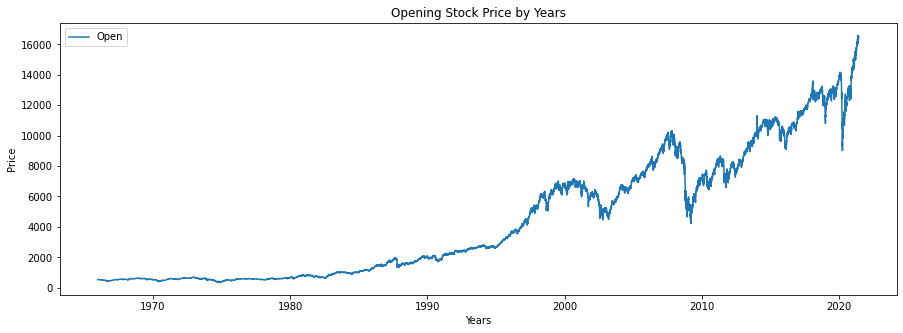

In [ ]:
fig1, ax1 = plt.subplots(figsize = (15,5))

ax1.plot(date, series1, label = 'Open')
ax1.legend()
ax1.set_title('Opening Stock Price by Years')
ax1.set_xlabel('Years');
ax1.set_ylabel('Price');

## Part IV: Data Split and Windowing

In [25]:
train_series, test_series = train_test_split(series1, shuffle=False, test_size = 0.2)

In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [57]:
train_set = windowed_dataset(train_series, window_size = 5, batch_size = 50, shuffle_buffer = 1000)
validation_set = windowed_dataset(test_series, window_size = 5, batch_size = 50, shuffle_buffer = 1000)

## Part V: Model Creation

### Function Definition

In [58]:
def initialize_model(name, loss, optimizer, metrics):
  model = Sequential(name = name)

  model.add(LSTM(
      units = 512,
      return_sequences = True
      )
  )
  model.add(LSTM(
      units = 256,
      dropout = 0.5,
      return_sequences = True
      )
  )
  model.add(LSTM(
      units = 128,
      dropout = 0.5,
      )
  )
  model.add(Dense(
      units = 2048,
      activation = 'relu',
      kernel_initializer = 'he_uniform'
      )
  )
  model.add(Dropout(
      rate = 0.5
      )
  )
  model.add(Dense(
      units = 1024,
      activation = 'relu',
      kernel_initializer = 'he_uniform'
      )
  )
  model.add(Dropout(
      rate = 0.5
      )
  )
  model.add(Dense(
      units = 512,
      activation = 'relu',
      kernel_initializer = 'he_uniform'
      )
  )
  model.add(Dropout(
      rate = 0.5
      )
  )
  model.add(Dense(
      units = 256,
      activation = 'relu',
      kernel_initializer = 'he_uniform'
      )
  )
  model.add(Dropout(
      rate = 0.5
      )
  )
  model.add(Dense(
      units = 1,
      activation = 'linear',
      )
  )

  model.compile(loss = loss, optimizer = optimizer, metrics = [metrics])

  return model

### Model Initialization

In [59]:
optimizers = Adam(learning_rate=0.00001)
loss = Huber(delta=1.0)
metrics = 'mae'

In [60]:
Predictor1 = initialize_model('Predictor1', loss, optimizers, metrics)

## Part V: Train Model

### Define Callbacks

In [61]:
es1 = EarlyStopping(monitor='mae', mode='min', verbose=1, patience=10)
mc1 = ModelCheckpoint('best_model1.h5', monitor='val_mae', mode='min', verbose=1, save_best_only=True)

### Train Process

In [62]:
history1 = Predictor1.fit(train_set, validation_data = validation_set, epochs = 100,  callbacks = [es1, mc1], verbose=1)

Epoch 1/100
224/224 [==============================] - 13s 31ms/step - loss: 2879.2910 - mae: 2879.7915 - val_loss: 10547.4775 - val_mae: 10547.9766

Epoch 00001: val_mae improved from inf to 10547.97656, saving model to best_model1.h5
Epoch 2/100
224/224 [==============================] - 6s 26ms/step - loss: 1716.4265 - mae: 1716.9263 - val_loss: 6779.0605 - val_mae: 6779.5596

Epoch 00002: val_mae improved from 10547.97656 to 6779.55957, saving model to best_model1.h5
Epoch 3/100
224/224 [==============================] - 6s 25ms/step - loss: 2455.0735 - mae: 2455.5728 - val_loss: 7560.0137 - val_mae: 7560.5142

Epoch 00003: val_mae did not improve from 6779.55957
Epoch 4/100
224/224 [==============================] - 6s 28ms/step - loss: 2218.1233 - mae: 2218.6235 - val_loss: 7442.3413 - val_mae: 7442.8408

Epoch 00004: val_mae did not improve from 6779.55957
Epoch 5/100
224/224 [==============================] - 6s 25ms/step - loss: 1695.5527 - mae: 1696.0525 - val_loss: 6486.9570

### Training Results

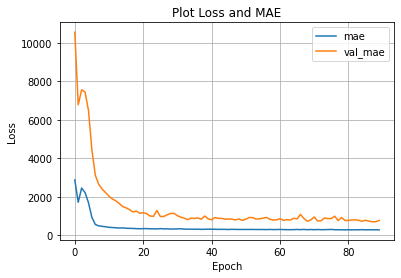

In [63]:
plt.plot(history1.history['mae'], label='mae')
plt.plot(history1.history['val_mae'], label='val_mae')

plt.title("Plot Loss and MAE")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()